In [0]:
from fastai import *
from fastai.tabular import *
import pandas as pd
from torchsummary import summary
import torch
from torch import nn
import imageio
import torch
import glob
from fastai.vision import *
import os
from torch import nn
import torch.nn.functional as F

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount = Truex)
%cd "/content/drive/My Drive/automatic-asset-classification"
%ls "/content/drive/My Drive/automatic-asset-classification"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/automatic-asset-classification
data/


In [0]:
image_path = "/content/drive/My Drive/automatic-asset-classification/data/final_dataset"
size = 28
batchsize = 32
tfms = get_transforms(do_flip = False)
src = (ImageImageList.from_folder(image_path, convert_mode = 'L').split_by_rand_pct(seed=2).\
       label_from_func(lambda x: x, convert_mode = 'L'))
data = (src.transform(size=size, tfm_y=True)
        .databunch(bs=batchsize)
        .normalize(do_y = False))

In [0]:
class LinearAutoEncoder(nn.Module):

    def __init__(self):
        super(LinearAutoEncoder, self).__init__()
        self.size = 28
        self.layer_outs = [int(self.size**2//(6.125**i)) for i in range(3)];
        self.enc = [];
        self.dec = [];

        for i in range(len(self.layer_outs) - 1):
            self.enc += [
                nn.Linear(self.layer_outs[i], self.layer_outs[i+1]),
                nn.BatchNorm1d(self.layer_outs[i+1], eps=1e-05, momentum=0.1, affine=True, 
                               track_running_stats=True),
                nn.Tanh()
            ]
            
        self.layer_outs.reverse()
        for i in range(len(self.layer_outs) - 1):
            self.dec += [
                nn.Linear(self.layer_outs[i], self.layer_outs[i+1]),
                nn.BatchNorm1d(self.layer_outs[i+1], eps=1e-05, momentum=0.1, affine=True, 
                               track_running_stats=True),
                nn.Tanh()
            ]

        self.encoder = nn.Sequential(*self.enc)
        self.decoder = nn.Sequential(*self.dec)

        
    def encode(self, x): return self.encoder(x)
    
    def decode(self, x): return self.decoder(x)

    def forward(self, x):
        x = x.view(-1, self.size**2)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.reshape([-1,1,self.size,self.size])
        return decoded

In [0]:
data

ImageDataBunch;

Train: LabelList (387 items)
x: ImageImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /content/drive/My Drive/automatic-asset-classification/data/final_dataset;

Valid: LabelList (96 items)
x: ImageImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /content/drive/My Drive/automatic-asset-classification/data/final_dataset;

Test: None

In [0]:
ae = LinearAutoEncoder();

In [0]:
learn = Learner(data, ae, loss_func=F.mse_loss);

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,0.626237,0.371411,01:37


In [0]:
learn.lr_find();

epoch,train_loss,valid_loss,time
0,0.569493,#na#,00:09
1,0.568157,#na#,00:08
2,0.567111,#na#,00:08
3,0.563498,#na#,00:08
4,0.550219,#na#,00:08
5,0.511084,#na#,00:08
6,0.417264,#na#,00:08
7,0.381717,#na#,00:09


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


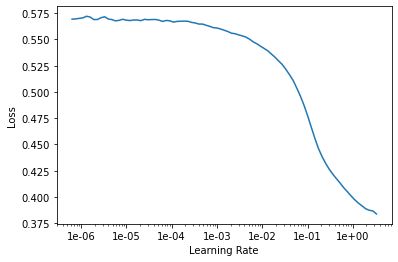

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(20, max_lr = 1e-02)

epoch,train_loss,valid_loss,time
0,0.549161,0.478769,00:11
1,0.523648,0.485039,00:11
2,0.490135,0.468369,00:11
3,0.453527,0.368960,00:11
4,0.406648,0.237161,00:11
5,0.349429,0.127371,00:11
6,0.291109,0.069888,00:11
7,0.236491,0.046766,00:11
8,0.189646,0.033210,00:11
9,0.151367,0.025089,00:11


validation loss is still decreasing so this can be trained for a few more epochs...

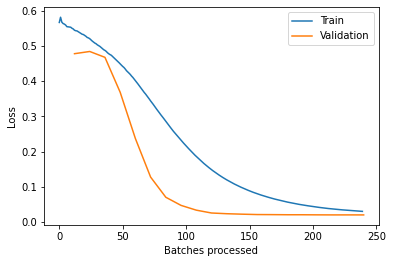

In [0]:
learn.recorder.plot_losses();

However looks like it slowed down so not worth it.

In [0]:
learn.save('smaller_net')

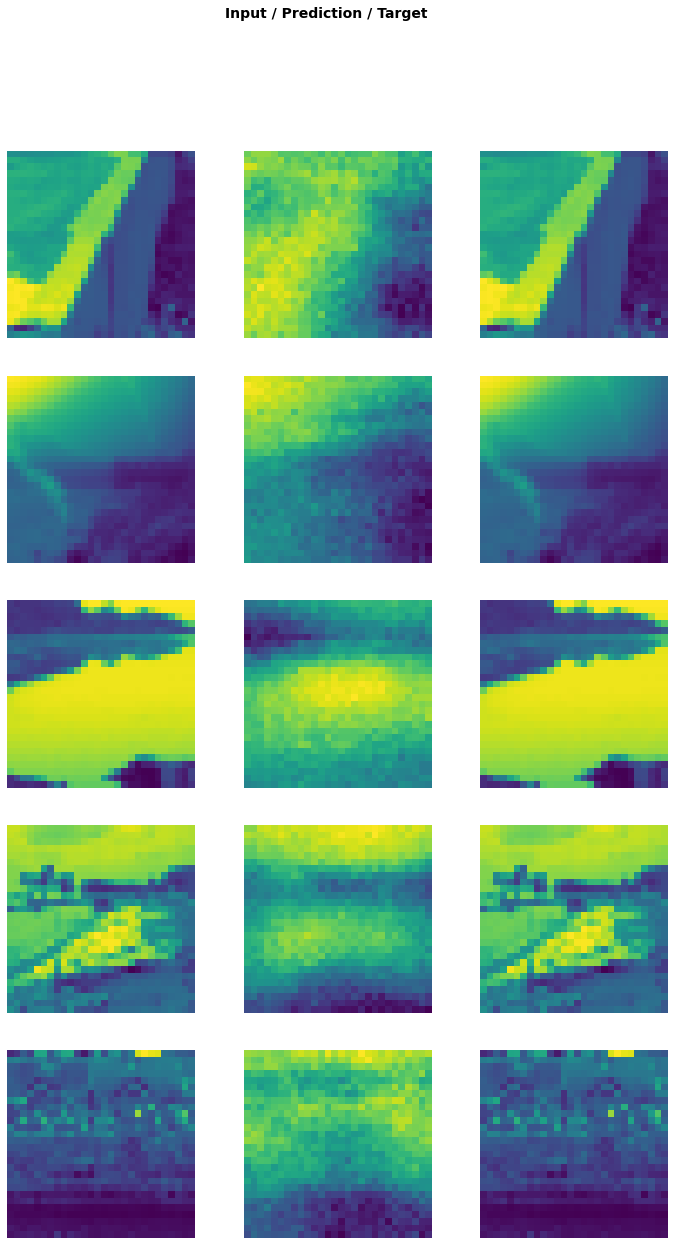

In [0]:
learn.show_results(ds_type=DatasetType.Valid)

In [0]:
class LinearAutoEncoder(nn.Module):

    def __init__(self):
        super(LinearAutoEncoder, self).__init__()
        self.size = 28
        self.layer_outs = [int(self.size**2//(6.125**i)) for i in range(3)];
        self.enc = [];
        self.dec = [];

        for i in range(len(self.layer_outs) - 1):
            self.enc += [
                nn.Linear(self.layer_outs[i], self.layer_outs[i+1]),
                nn.BatchNorm1d(self.layer_outs[i+1], eps=1e-05, momentum=0.1, affine=True, 
                               track_running_stats=True),
                nn.ReLU(inplace = True)
            ]
            
        self.layer_outs.reverse()
        for i in range(len(self.layer_outs) - 1):
            self.dec += [
                nn.Linear(self.layer_outs[i], self.layer_outs[i+1]),
                nn.BatchNorm1d(self.layer_outs[i+1], eps=1e-05, momentum=0.1, affine=True, 
                               track_running_stats=True),
                nn.ReLU(inplace=True)
            ]

        self.encoder = nn.Sequential(*self.enc)
        self.decoder = nn.Sequential(*self.dec)

        
    def encode(self, x): return self.encoder(x)
    
    def decode(self, x): return self.decoder(x)

    def forward(self, x):
        x = x.view(-1, self.size**2)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.reshape([-1,1,self.size,self.size])
        return decoded

In [0]:
ae2 = LinearAutoEncoder();

In [0]:
learn2 = Learner(data, ae, loss_func=F.mse_loss);

In [0]:
learn2.lr_find();

epoch,train_loss,valid_loss,time
0,0.018452,#na#,00:09
1,0.018480,#na#,00:09
2,0.018378,#na#,00:09
3,0.018491,#na#,00:08
4,0.018370,#na#,00:09
5,0.018365,#na#,00:08
6,0.020047,#na#,00:08
7,0.028467,#na#,00:09


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


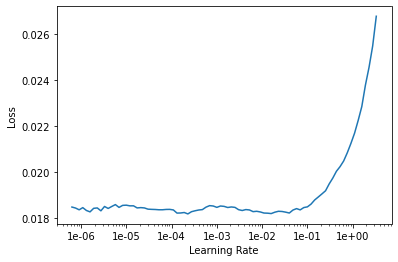

In [0]:
learn2.recorder.plot()

In [0]:
learn2.fit_one_cycle(20, max_lr = 1e-02)

epoch,train_loss,valid_loss,time
0,0.018582,0.019354,00:12
1,0.018304,0.018959,00:12
2,0.018079,0.019555,00:12
3,0.017896,0.018497,00:12
4,0.017680,0.018102,00:12
5,0.017454,0.017547,00:12
6,0.017095,0.016886,00:12
7,0.016772,0.017025,00:12
8,0.016424,0.015967,00:12
9,0.016000,0.015536,00:12


ERROR! Session/line number was not unique in database. History logging moved to new session 59


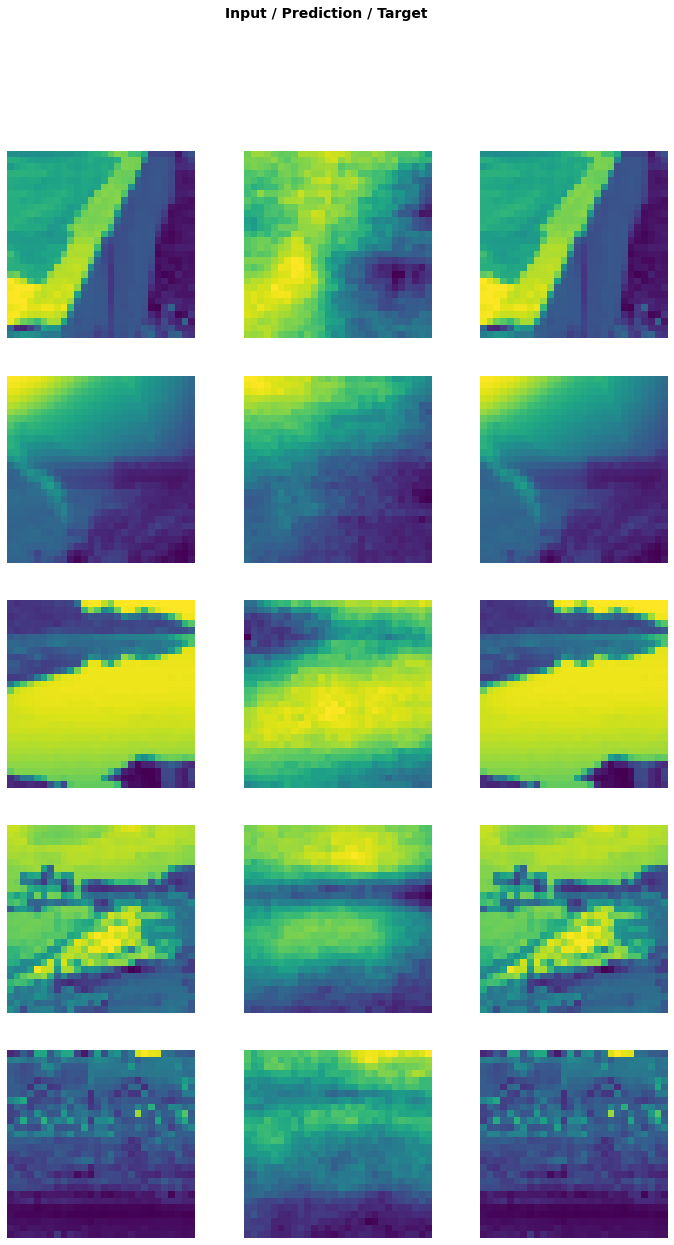

In [0]:
learn2.show_results();

In [0]:
learn2.lr_find();

epoch,train_loss,valid_loss,time
0,0.012097,#na#,00:08
1,0.011898,#na#,00:08
2,0.011781,#na#,00:08
3,0.011836,#na#,00:08
4,0.011813,#na#,00:08
5,0.012212,#na#,00:08
6,0.015174,#na#,00:08
7,0.025663,#na#,00:08


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


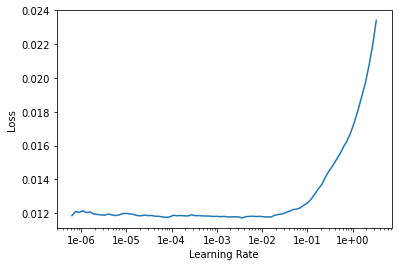

In [0]:
learn2.recorder.plot();

In [0]:
learn2.fit_one_cycle(50, max_lr = 1e-03)

epoch,train_loss,valid_loss,time
0,0.011976,0.013847,00:11
1,0.011784,0.013867,00:11
2,0.011758,0.013879,00:11
3,0.011706,0.013908,00:11
4,0.011680,0.013822,00:11
5,0.011675,0.013823,00:11
6,0.011667,0.013758,00:11
7,0.011769,0.013855,00:11
8,0.011791,0.013790,00:11
9,0.011700,0.013823,00:11


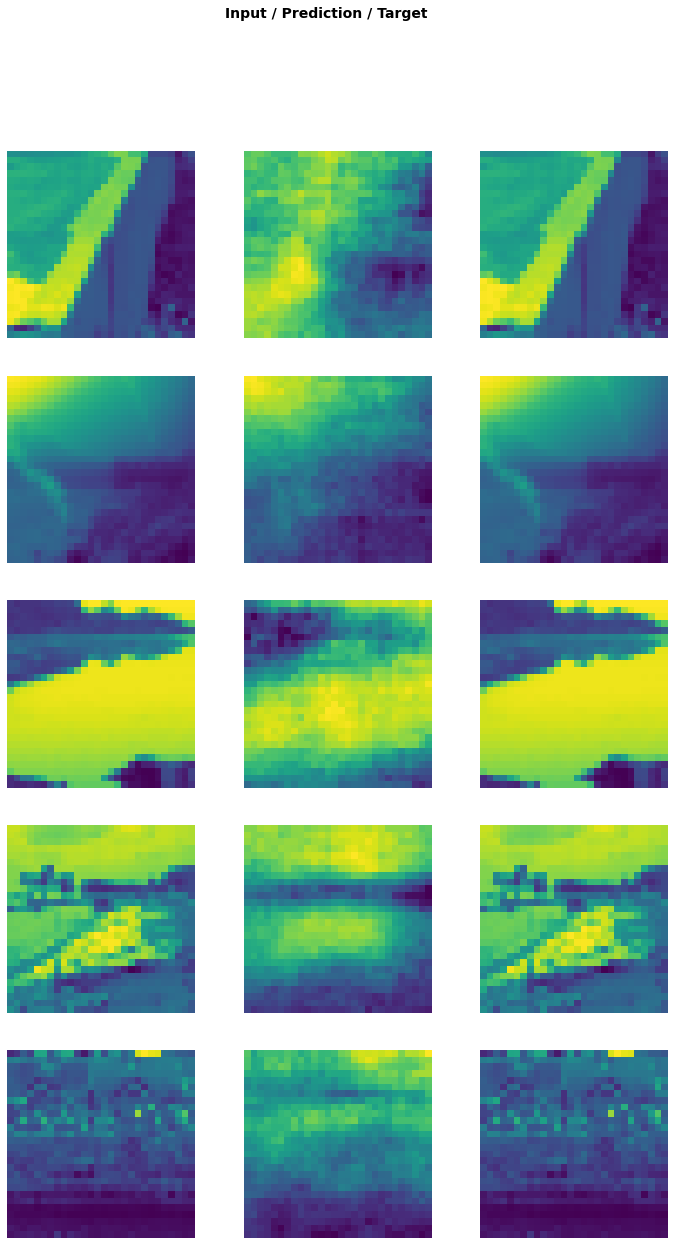

In [0]:
learn2.show_results();

In [0]:
learn2.fit_one_cycle(200, max_lr = 1e-03)

epoch,train_loss,valid_loss,time
0,0.010676,0.013538,00:12
1,0.010443,0.013508,00:12
2,0.010431,0.013531,00:12
3,0.010458,0.013516,00:12
4,0.010563,0.013531,00:11
5,0.010536,0.013486,00:11
6,0.010438,0.013494,00:12
7,0.010501,0.013485,00:11
8,0.010426,0.013476,00:11
9,0.010480,0.013536,00:12


In [0]:
data.train_ds.[0].numpy();

SyntaxError: ignored

ERROR! Session/line number was not unique in database. History logging moved to new session 60
